# Beta Diversity Analysis, Rarefaction and Significance Tests

        

## 0. Set_up

In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiime2 as q2
from skbio import OrdinationResults
from qiime2 import Visualization
import matplotlib.pyplot as plt
from seaborn import scatterplot

%matplotlib inline

In [2]:
data_dir ='project_data'

In [3]:
ls

A_FirstLook.ipynb                figures/
B_Eating_habits.ipynb            G_Beta_Diversity.ipynb
C_Sequence_import.ipynb          H_DifferentialAbundance.ipynb
D_Taxonomy_NCBI.ipynb            I_Metagenomics.ipynb
D_Taxonomy_pre-classifier.ipynb  J_Functional_Redoundancy_and_Stability.ipynb
D_Taxonomy_SILVA.ipynb           project_data/
E_Phylogeny.ipynb                Z_GanttChart.ipynb
F_Alpha_Diversity.ipynb


In order to run this code, you need results of functions done on previous file : 
- `metadata` gathering is done in file A
- `diversity computation` is done in file F

<a id='sec1'></a>

## 1. Import metadata

Metadata of refers to students additional informations we collected into the file "sample_meta_data.tsv".

In [14]:
df_meta = pd.read_csv(f'{data_dir}/sample_meta_data.tsv', sep='\t')

## 2.Compute diversity

Beta diversity measures the similarity between samples or groups of samples.        
To inspect groupings of beta diversity metrics across metadata categories, we will start by inspecting the principal coordinates (PCoA) plots created with the `qiime diversity core-metrics-phylogenetic` method in file F (directory core-metrics-results)

#### **Selection of categorical variables of interest**

In [23]:
df_cat = df_meta.select_dtypes(include=['object'])
df_cat.describe()

,GEN_age_cat,GEN_bmi_cat,GEN_collection_timestamp,GEN_country,GEN_geo_loc_name,GEN_host_common_name,GEN_last_move,GEN_last_travel,GEN_level_of_education,GEN_race,...,NUT_probiotic_frequency,NUT_red_meat_frequency,NUT_salted_snacks_frequency,NUT_seafood_frequency,NUT_sugary_sweets_frequency,NUT_vegetable_frequency,NUT_vitamin_b_supplement_frequency,NUT_vitamin_d_supplement_frequency,NUT_whole_eggs,NUT_whole_grain_frequency
count,523,523,523,523,523,523,523,523,523,523,...,523,523,523,523,523,523,523,523,523,523
unique,9,5,505,17,62,1,6,6,8,6,...,6,6,6,6,6,6,6,6,6,6
top,50s,Normal,2016-08-01 08:00:00,United Kingdom,United Kingdom:England,human,I have lived in my current state of residence ...,I have not been outside of my country of resid...,Graduate or Professional degree,Caucasian,...,Never,Occasionally,Rarely,Occasionally,Rarely,Daily,Never,Never,Occasionally,Regularly
freq,121,274,5,255,169,523,475,168,232,474,...,216,200,198,232,150,260,328,268,215,147


In [26]:
for col in df_cat.columns:
    print(col)

GEN_age_cat
GEN_bmi_cat
GEN_collection_timestamp
GEN_country
GEN_geo_loc_name
GEN_host_common_name
GEN_last_move
GEN_last_travel
GEN_level_of_education
GEN_race
GEN_sample_type
GEN_sex
NUT_alcohol_frequency
NUT_artificial_sweeteners
NUT_diet_type
NUT_drinks_per_session
NUT_fed_as_infant
NUT_fermented_plant_frequency
NUT_frozen_dessert_frequency
NUT_fruit_frequency
NUT_gluten
NUT_high_fat_red_meat_frequency
NUT_homecooked_meals_frequency
NUT_meat_eggs_frequency
NUT_milk_cheese_frequency
NUT_milk_substitute_frequency
NUT_olive_oil
NUT_poultry_frequency
NUT_prepared_meals_frequency
NUT_probiotic_frequency
NUT_red_meat_frequency
NUT_salted_snacks_frequency
NUT_seafood_frequency
NUT_sugary_sweets_frequency
NUT_vegetable_frequency
NUT_vitamin_b_supplement_frequency
NUT_vitamin_d_supplement_frequency
NUT_whole_eggs
NUT_whole_grain_frequency


In [3]:
md = q2.Metadata.load(data_dir + '/sample_meta_data.tsv').to_dataframe()
pd.DataFrame([str(sorted(md[col].astype(str).unique())) for col in md.columns],
             index=pd.Index(md.columns, name='Column'), columns=['Values'])

,Values
Column,
GEN_age_cat,"['20s', '30s', '40s', '50s', '60s', '70+', 'No..."
GEN_age_corrected,"['11.0', '14.0', '15.0', '16.0', '17.0', '18.0..."
GEN_bmi_cat,"['Normal', 'Not provided', 'Obese', 'Overweigh..."
GEN_bmi_corrected,"['11.2', '11.57', '14.34', '14.62', '14.79', '..."
GEN_cat,"['False', 'True']"
GEN_collection_timestamp,"['2014-05-10 12:00:00', '2015-01-01 09:00:00',..."
GEN_country,"['Australia', 'Belgium', 'Canada', 'Georgia', ..."
GEN_dog,"['False', 'True']"
GEN_elevation,"['-0.9', '0.0', '1.4', '10.4', '10.8', '10.9',..."


Almost all the variables present in the dataframe df_cat can be interesting to test for beta-analysis. However, for the purpose of our research goals here, we will focus on data about age, BMI, country, level of education

## 3. Visual inspection

**a)** 3D PCoA plots inspection

In [ ]:
Visualization.load(f'{data_dir}/core-metrics-results/weighted_unifrac_emperor.qzv')

In [7]:
Visualization.load(f'{data_dir}/core-metrics-results/bray_curtis_emperor.qzv')

<visualization: Visualization uuid: 6af57913-dd4b-427b-a22e-4aaaeb32c554>

**b)** 2D plot of main PCoA axis

In [4]:
pcs = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results/weighted_unifrac_pcoa_results.qza'))
pcs = pcs.view(OrdinationResults)
pcs_data = pcs.samples.iloc[:,:3]
pcs_data.columns = ['Axis 1', 'Axis 2', 'Axis 3']

In [5]:
pcs_data.head()

,Axis 1,Axis 2,Axis 3
10317.000002929,-0.144197,-0.023014,0.022661
10317.000002930,-0.139421,-0.016882,0.178423
10317.000003283,0.026313,0.051591,0.002213
10317.000004079,-0.150133,0.030451,-0.045630
10317.000016169,-0.069590,0.008753,-0.035616


In [6]:
pcs_data_with_md = pcs_data.join(md['NUT_lowgrain_diet_type'])

<AxesSubplot:xlabel='Axis 1', ylabel='Axis 2'>

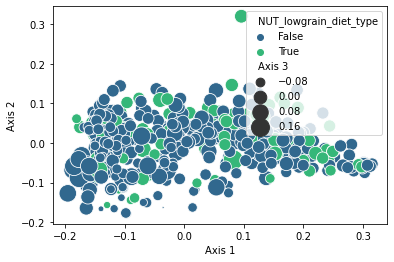

In [8]:
scatterplot(data=pcs_data_with_md,
x='Axis 1',
y='Axis 2',
hue='NUT_lowgrain_diet_type',
size='Axis 3',
sizes=(4, 400),


palette='viridis')


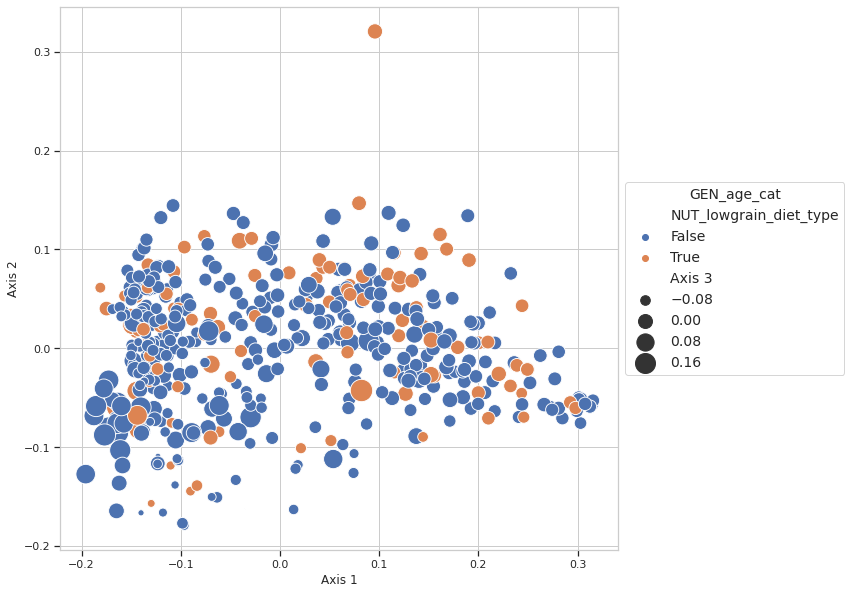

In [38]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    sns.set(rc={'figure.figsize':(10,10)}, style='white')
    sns.scatterplot(data=pcs_data_with_md, x='Axis 1', y='Axis 2', ax=ax, hue=pcs_data_with_md['NUT_lowgrain_diet_type'], size='Axis 3',
sizes=(1, 500))
        
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=14)
    legend = ax.get_legend()
    legend.set_title('GEN_age_cat')
    

    ax.tick_params(axis='x', which='major', bottom=True) 
    ax.tick_params(axis='y', which='major', left=True)

## 4.Statistical analysis

#### **Non-parametric multivariate analysis of variance : PERMANOVA testing of variable**

Associations between beta diversity and categorical variables can be statistically tested using a PERMANOVA test. This is a non-parametric statistical test that checks the null hypothesis that the distances between samples of one group are equivalent to distances to samples of another group. If this null hypothesis is rejected, we can infer that the distances between samples of one group differ significantly from the distances to samples in at least one other group. We can perform a PERMANOVA test checking whether the observed categories are significantly grouped in QIIME 2 with the `qiime diversity beta-group-significance` method: 

In [40]:
os.mkdir('/home/jovyan/HealthyFood/JupyterDocs/project_data/core-metrics-results-bd')

**a)** Example : variable "NUT_prepared_meals_frequency"

##### *with  weighted UniFrac distance matrix*

In [124]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column NUT_prepared_meals_frequency \
--p-pairwise \
--o-visualization $data_dir/core-metrics-results-bd/wu_pmf-significance.qzv

Saved Visualization to: project_data/core-metrics-results-bd/wu_pmf-significance.qzv


In [4]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/wu_pmf-significance.qzv')

<visualization: Visualization uuid: c4d03365-0fd8-4fcc-a12b-be094d273ebb>

##### *with Bray curtis distance matrix*

In [13]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --m-metadata-column NUT_prepared_meals_frequency \
--p-pairwise \
--o-visualization $data_dir/core-metrics-results-bd/bc_pmf-significance.qzv

Saved Visualization to: project_data/core-metrics-results-bd/bc_pmf-significance.qzv


In [14]:
Visualization.load(f'{data_dir}/core-metrics-results-bd/bc_pmf-significance.qzv')

<visualization: Visualization uuid: 5387dadf-ce58-4cdc-944e-cf2f9b66e253>

#### **Adonis implementation of PERMANOVA tests : Multfactor testing**

The `adonis` implementation of PERMANOVA (part of the r-vegan package) accepts a formula as input, which can consist of one or more independent terms. This might be useful for testing which covariates explain the most variation in our datasets.

### Hypothesis 1 : Milk products 

In [18]:
# testing with bray curtis matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_milk_cheese_frequency*NUT_milk_substitute_frequency*NUT_vitamin_d_supplement_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-bc-H1.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-bc-H1.qzv')

Saved Visualization to: project_data/core-metrics-results-bd/adonis-bc-H1.qzv


<visualization: Visualization uuid: fd93e8b0-5e12-4b18-a3d6-8caaff2e0a0c>

In [19]:
# testing with weighted UniFrac matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_milk_cheese_frequency*NUT_milk_substitute_frequency*NUT_vitamin_d_supplement_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H1.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H1.qzv')

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H1.qzv


<visualization: Visualization uuid: afff41c9-9e23-48ca-a2fa-02e0887b7f6e>

### Hypothesis 2 : Mediterranean diet

In [20]:
# testing with bray curtis matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_olive_oil*NUT_seafood_frequency*NUT_vegetable_frequency*NUT_fruit_frequency*NUT_whole_grain_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-bc-H2.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-bc-H2.qzv')

Saved Visualization to: project_data/core-metrics-results-bd/adonis-bc-H2.qzv


<visualization: Visualization uuid: 9caf9b29-995e-478c-a873-332d86e66856>

In [21]:
# testing with weighted unifrac matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_olive_oil*NUT_seafood_frequency*NUT_vegetable_frequency*NUT_fruit_frequency*NUT_whole_grain_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H2.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H2.qzv')

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H2.qzv


<visualization: Visualization uuid: 6c98d89e-09b1-426d-aa92-554aa94fe40b>

### Hypothesis 3 : Poultry and Meat

In [3]:
# testing with bray curtis matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_whole_eggs*NUT_poultry_frequency*NUT_high_fat_red_meat_frequency*NUT_meat_eggs_frequency*NUT_red_meat_frequency*NUT_vitamin_b_supplement_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-bc-H3.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-bc-H3.qzv')

^C


ValueError: project_data/core-metrics-results-bd/adonis-bc-H3.qzv does not exist.

In [ ]:
# testing with weighted unifrac matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_whole_eggs*NUT_poultry_frequency*NUT_high_fat_red_meat_frequency*NUT_meat_eggs_frequency*NUT_red_meat_frequency*NUT_vitamin_b_supplement_frequency" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H3.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H3.qzv')

### Hypothesis 4 : Drinks

In [5]:
# testing with bray curtis matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_alcohol_frequency*NUT_drinks_per_session" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-bc-H4.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-bc-H4.qzv')

Saved Visualization to: project_data/core-metrics-results-bd/adonis-bc-H4.qzv


<visualization: Visualization uuid: 981c5ac7-1c8d-48b0-8f6c-089af083e8c0>

In [6]:
# testing with weighted unifrac matrix
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/sample_meta_data.tsv \
    --p-formula "NUT_alcohol_frequency*NUT_drinks_per_session" \
    --o-visualization $data_dir/core-metrics-results-bd/adonis-wu-H4.qzv
Visualization.load(f'{data_dir}/core-metrics-results-bd/adonis-wu-H4.qzv')

Saved Visualization to: project_data/core-metrics-results-bd/adonis-wu-H4.qzv


<visualization: Visualization uuid: fb239e0e-c301-4b1e-8245-73585b56e2d4>